## **Importing the necessary libraries**

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows",None)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

## **Importing the dataset**

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


First, we need to check if the data in the dataframe has the correct data type.

In [3]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

After checking the data types of each column, we can observe that instead of having a string data type, the data is in object form. For this reason, we will convert it to string.

In [4]:
string_col = df.select_dtypes(include='object').columns
df[string_col] = df[string_col].astype('string')

Confirming if the object data types were successfully converted to string data type.

In [5]:
df.dtypes

Age                 int64
Sex                string
ChestPainType      string
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         string
MaxHR               int64
ExerciseAngina     string
Oldpeak           float64
ST_Slope           string
HeartDisease        int64
dtype: object

Next, we will separate the Categorical features and the Numerical features.

In [6]:
# Getting the categorical features
string_col = df.select_dtypes("string").columns.to_list()
print("Categorical Features: ", string_col)

Categorical Features:  ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [7]:
# Getting the numerical features
num_col = df.columns.to_list()
for col in string_col:
    num_col.remove(col)
num_col.remove("HeartDisease")

print("Numerical Features: ", num_col)

Numerical Features:  ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


## **Exploratory Data Analysis**
Analyzing the dataset to fully understand the data.

Checking the correlation of variables leading to Heart Disease.

In [9]:
px.imshow(df.corr().round(2), text_auto=True, color_continuous_scale=px.colors.diverging.RdBu_r, title="Correlation Plot of Variables", height=800, width=800)

Finding the age group that experiences heart disease the most.

In [10]:
fig = px.histogram(df, 
                   x="Age",
                   y="HeartDisease",
                   text_auto='True',
                   title="Distribution of Heart Diseases According to Age Group",
                   barmode='group' 
                  )
fig.update_layout(xaxis_range=[25,80], bargap=0.40)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

Checking the distribution of the occurence of heart disease according to sex.

In [11]:
fig=px.histogram(df, 
                 x="HeartDisease",
                 text_auto='True',
                 color= 'Sex',
                 title="Distribution of Heart Diseases According to Sex",
                 barmode='group'
                )
fig.update_layout(yaxis_range=[0,600], bargap=0.20)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

Checking the most common type of chest pain experienced by the patients. 

In [12]:
fig=px.histogram(df,
                 x="ChestPainType",
                 text_auto='True',
                 color='Sex',
                 title="Types of Chest Pain",
                )
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

Visualizing the variable distribution of Oldpeak and HeartDisease

In [13]:
hist_data = [df.Oldpeak.tolist(), df.HeartDisease.tolist()]
group_labels = ["Oldpeak", "HeartDisease"]

fig = ff.create_distplot(hist_data, 
                         group_labels,
                         show_hist=False,
                         show_rug=False
                        )
fig.layout = go.Layout(
    title='Distribution of Oldpeak and HeartDisease',
    xaxis=dict(
        title="Seconds"
    ),
    yaxis=dict(
        title="Probability"
    ) ) 
fig.show()

## **Data Preprocessing**
### Handling Outliers
Checking for outliers or data points that differ significantly from the rest of the dataset. This will be shown through a `box-and-whisker plot` which displays the distribution of data.


In [14]:
# Only the numerical features will be checked for outliers.
for col in num_col:
    if col != "FastingBS": # Even though FastingBS has an integer datatype, it is a binary variable which is why it is excluded.
        if col == "RestingBP": 
            fig = px.box(df, y=col, x="HeartDisease", title= f"Distrubution of {col}", color="Sex")
        else:
            fig = px.box(df, y=col, x="HeartDisease", title= f"Distrubution of {col}")
        fig.show()

### Handling Null Values
Checking for null values or missing values in the dataset.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    string 
 2   ChestPainType   918 non-null    string 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    string 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    string 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    string 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), string(5)
memory usage: 86.2 KB


In [16]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Encoding Categorical Features
Since neural network models can only work with numercial data, the categorical features will be assigned a unique integer value using `LabelEncoder`. 

In [17]:
# Creating a dataframe to store the encoded values
dfEncoded = df
dfEncoded = dfEncoded.apply(LabelEncoder().fit_transform)

# Creating a key to decode the encoded values
Key = []
dfKey = pd.DataFrame(Key, columns=['Feature', 'Encoded', 'Original'])

# Droping all rows in dfKey
dfKey = dfKey.drop(dfKey.index, axis=0)
# Assigning the categorical features with its corresponding encoded values
for col in string_col:
    for unique in dfEncoded[col].unique():
        Key.append([col, unique, df[col][dfEncoded[col] == unique].unique()[0]])

# Organizing the key
dfKey = pd.DataFrame(Key, columns=['Feature', 'Encoded', 'Original'])
dfKey = dfKey.sort_values(by=['Feature', 'Encoded'], ignore_index=True)

# Transforming the key to create multiple rows for each feature
dfKey = dfKey.pivot(index='Feature', columns='Encoded', values='Original').reset_index()
dfKey


Encoded,Feature,0,1,2,3
0,ChestPainType,ASY,ATA,NAP,TA
1,ExerciseAngina,N,Y,NaN,NaN
2,RestingECG,LVH,Normal,ST,NaN
3,ST_Slope,Down,Flat,Up,NaN
4,Sex,F,M,NaN,NaN


## **Creating the Neural Network Model**

Splitting the dataset into training and testing sets

In [18]:
from sklearn.model_selection import train_test_split
x_test, x_train, y_test, y_train = train_test_split(dfEncoded.drop('HeartDisease', axis=1), dfEncoded['HeartDisease'], test_size=0.2, random_state=42)

Creating a function that creates models with varying hyperparameters.

In [19]:
from keras_tuner.tuners import RandomSearch
import os

def ModelMaker(Epoch, Optimizer):
    # Creating a folder to save the model
    accuracy= [0,1]
    if not os.path.exists(f"Model_{Epoch}_{Optimizer}"):
        os.mkdir(f"Model_{Epoch}_{Optimizer}")
    for layer in range(1, 4):
        for nodesPerLayer in range(30, 110, 10):
            for batchsizeexponent in range(4, 10):
                batchsize = 2**batchsizeexponent
                Model = keras.Sequential()
                for i in range(layer):
                   Model.add(keras.layers.Dense(nodesPerLayer, activation='relu'))
                Model.add(keras.layers.Dense(1, activation='sigmoid'))
                Model.compile(optimizer=Optimizer, loss='binary_crossentropy', metrics=['accuracy'])
                Model.fit(x_train, y_train, epochs=Epoch, batch_size=batchsize, verbose=0)
                accuracy = Model.evaluate(x_test, y_test, verbose=0)
                Model.save(f"Model_{Epoch}_{Optimizer}/Model_{layer}_{nodesPerLayer}_{batchsize}_{Epoch}_{Optimizer}_{round(accuracy[1], 4)}.h5")
                print(f"Model_{layer}_{nodesPerLayer}_{batchsize}_{Epoch}_{Optimizer}_{round(accuracy[1], 4)}")
                
                #Saving the model data in a csv file
                ModelData = pd.read_csv('ModelData.csv')
                ModelData = ModelData.append({'Layer': layer, 'NodesPerLayer': nodesPerLayer, 'BatchSize': batchsize, 'Epoch': Epoch, 'Optimizer': Optimizer, 'Accuracy': accuracy[1]}, ignore_index=True)
                ModelData.to_csv('ModelData.csv', index=False)

Running the ModelMaker function to generate models.

The code below has been commented out since the models have already been generated and its data have been stored in a database.There is no need to rerun the function again as it takes a long time to finish executing, however by removing the comments, we can generate the models and its data again.

In [20]:
# ModelData = pd.read_csv('ModelData.csv')
# # Droping all rows in df ModelData
# ModelData = ModelData.drop(ModelData.index, axis=0)
# ModelData.to_csv('ModelData.csv', index=False)

# Optimizer = ['Adam', 'Adamax', 'Nadam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta']
# Epoch = [50, 100, 200, 300, 400, 500]

# for Optimizer1 in Optimizer:
#     for Epoch1 in Epoch:
#         ModelMaker(Epoch1, Optimizer1)


Checking the model data in the ModelData.csv file.

In [21]:
# Reading the data from the csv file
ModelData = pd.read_csv('ModelData.csv')

# Sorting the data based on accuracy to identify the model with the highest accuracy
ModelData = ModelData.sort_values(by=['Accuracy'], ascending=False)
print(ModelData.head(100))

      Layer  NodesPerLayer  BatchSize  Epoch Optimizer  Accuracy
582       1             40         16    400      Adam  0.840599
596       1             60         64    400      Adam  0.840599
2449      1             30         32    500     Nadam  0.839237
2467      1             60         32    500     Nadam  0.839237
2166      1             40         16    300     Nadam  0.837875
4071      1             90        128    400   RMSprop  0.837875
1596      1             50         16    500    Adamax  0.836512
1164      1             50         16    200    Adamax  0.833787
3891      1             30        128    300   RMSprop  0.833787
3932      1            100         64    300   RMSprop  0.833787
4187      1             40        512    500   RMSprop  0.833787
584       1             40         64    400      Adam  0.832425
763       1            100         32    500      Adam  0.832425
180       1             90         16    100      Adam  0.832425
3613      1             5

## **DATA ANALYSIS FOR DIFFERENT MODELS**

### Comparison between the Optimizer and other Hyperparameters

Evaluates the effect of the Optimizers and the number of nodes per layer to the overall accuracy of the model

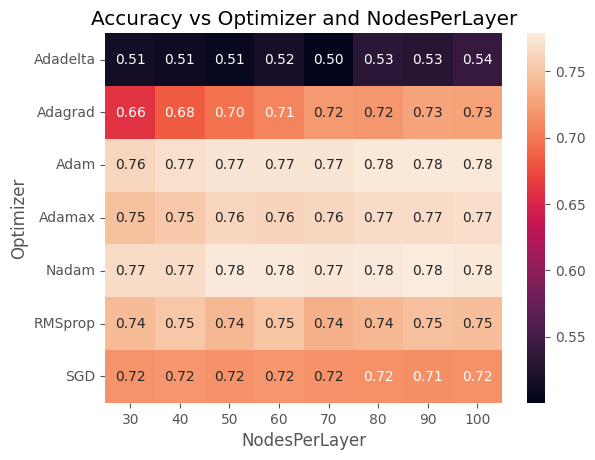

In [22]:
df_pivot = ModelData.pivot_table(values='Accuracy', index='Optimizer', columns='NodesPerLayer')

# Create a heatmap
sns.heatmap(df_pivot, annot=True, fmt='.2f')
plt.title("Accuracy vs Optimizer and NodesPerLayer")
plt.show()

Evaluating the effect of the Optimizers and the number of epochs to the overall accuracy of the model

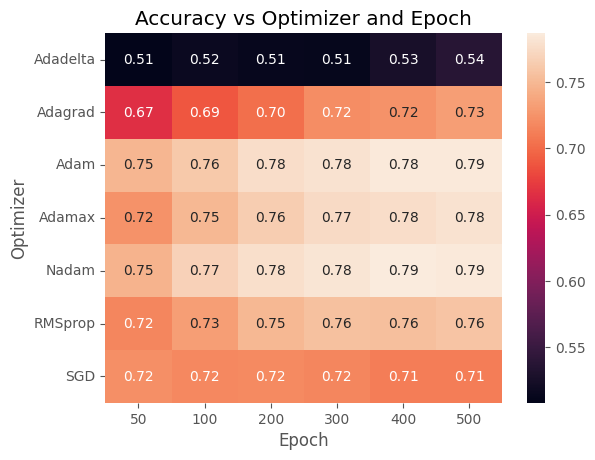

In [23]:
df_pivot = ModelData.pivot_table(values='Accuracy', index='Optimizer', columns='Epoch')

# Create a heatmap
sns.heatmap(df_pivot, annot=True, fmt='.2f')
plt.title("Accuracy vs Optimizer and Epoch")
plt.show()

Evaluating the effect of the Optimizers and the number of layer to the overall accuracy of the model

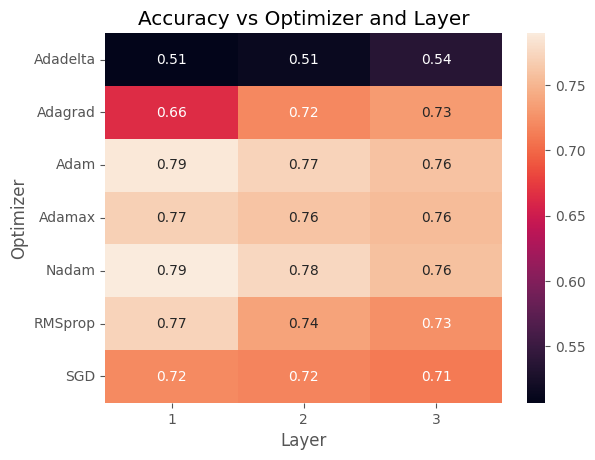

In [24]:
df_pivot = ModelData.pivot_table(values='Accuracy', index='Optimizer', columns='Layer')

# Create a heatmap
sns.heatmap(df_pivot, annot=True, fmt='.2f')
plt.title("Accuracy vs Optimizer and Layer")
plt.show()

Evaluating the effect of the Optimizers and the Batch Size to the overall accuracy of the model

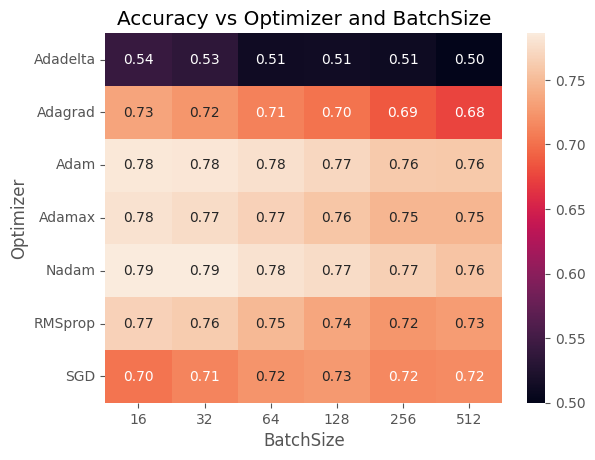

In [25]:
df_pivot = ModelData.pivot_table(values='Accuracy', index='Optimizer', columns='BatchSize')

# Create a heatmap
sns.heatmap(df_pivot, annot=True, fmt='.2f')
plt.title("Accuracy vs Optimizer and BatchSize")
plt.show()

### **MODEL ANALYSIS**

In [26]:
# Importing the necessary packages for model analysis
from keras.models import load_model
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

Loading the saved model with the highest accuracy

In [27]:
# Loading the model from the .h5 file
model = load_model('Model_1_40_16_400_Adam_0.8406.h5')

### Evaluating the model

In [28]:
# Evaluating the model on the test dataset
metrics = model.evaluate(x_test, y_test, batch_size=16)

# Printing the evaluation results
print("Loss: ", metrics[0])
print("Accuracy: ", metrics[1])

46/46 [==============================] - 1s 2ms/step - loss: 0.6810 - accuracy: 0.8406
Loss:  0.6810259222984314
Accuracy:  0.8405994772911072


### Making Predictions

In [29]:
# Make predictions on the test set
y_pred = model.predict(x_test)

# Convert the predictions to binary labels (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Print the results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1)

23/23 [==============================] - 0s 5ms/step
Precision:  0.8604060913705583
Recall:  0.8453865336658354
F1 score:  0.8528301886792452


### Confusion Matrix

23/23 [==============================] - 0s 2ms/step


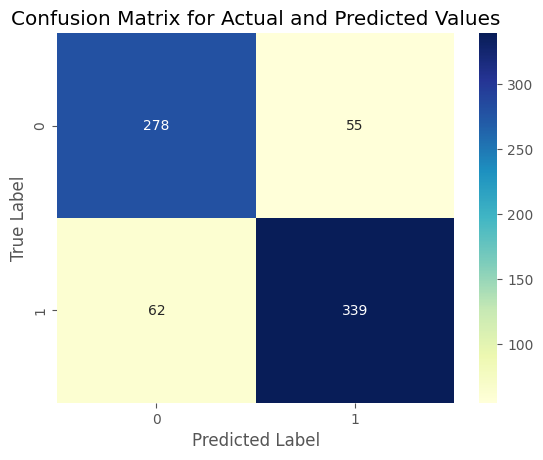

In [30]:
prediction = model.predict(x_test)
prediction = np.round(prediction)

confusionMatrix = confusion_matrix(y_test, prediction)

# Plot the confusion matrix using seaborn
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix for Actual and Predicted Values")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()